# Übung 12 - Local linear regression on concrete compressive strength

## Table of contents

### 1. Overview
### 2. Data handling
### 3. Estimating performances
### 4. Regularization with local linear regression


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#matplotlib.rcParams['mathtext.fontset'] = 'stix'
#matplotlib.rcParams['font.family'] = 'STIXGeneral'

## 1. Data overview

In [2]:
# load data from .csv file in dataframe
filename = "concrete_data.csv"
Data = pd.read_csv(filename)

In [3]:
Data

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [4]:
Data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
# check for unique values of every feature (to find nominal features)
Data.nunique()

cement                           278
blast_furnace_slag               185
fly_ash                          156
water                            195
superplasticizer                 111
coarse_aggregate                 284
fine_aggregate                   302
age                               14
concrete_compressive_strength    845
dtype: int64

In [6]:
# check for missing values
Data.isna().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

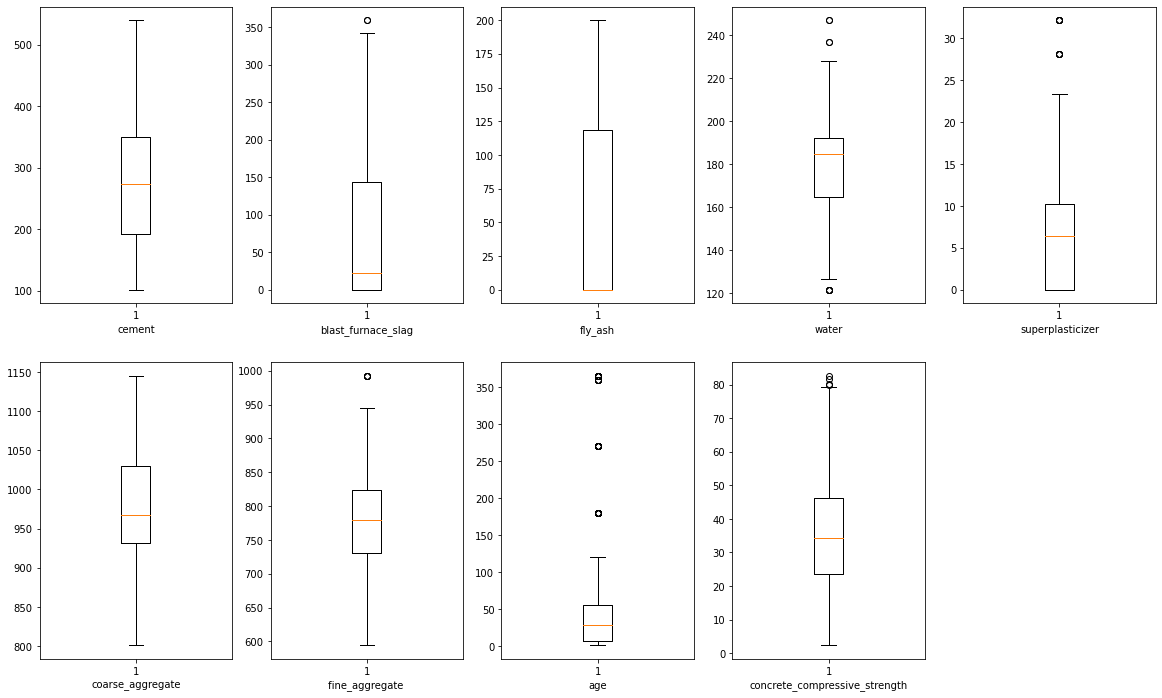

In [7]:
# value distribution for every feature
fig, axes = plt.subplots(2,5, figsize=(20,12))
for i, ax in enumerate(axes.flatten()):
    if i < 9:
        ax.boxplot(Data[Data.columns[i]])
        ax.set_xlabel(Data.columns[i])
    else:
        ax.set_visible(False)
plt.savefig('boxplots.png', bbox_inches='tight')
plt.show()

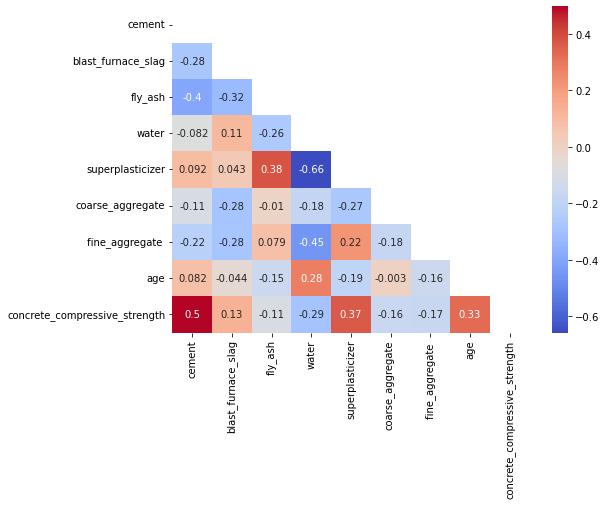

In [8]:
# correlation matrix
plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(Data.corr()))
sns.heatmap(Data.corr(), annot = True, cmap='coolwarm', mask=mask)
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

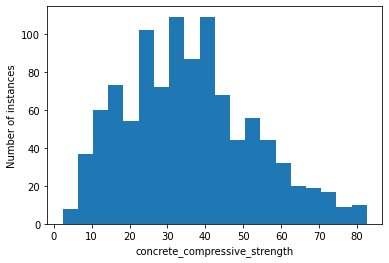

In [9]:
# Plot histogram of target variable
plt.hist(Data['concrete_compressive_strength'], bins=20)
plt.xlabel('concrete_compressive_strength')
plt.ylabel('Number of instances')
plt.savefig('target_hist.png', bbox_inches='tight')
plt.show()

## 2. Seperating target feature

In [10]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# load data
filename = "concrete_data.csv"
Data = pd.read_csv(filename)

# seperate target feature
X = Data.drop(['concrete_compressive_strength'], axis=1)
y = Data['concrete_compressive_strength']

## 3. Nested cross validation

In [11]:
def nested_cv(X, y, param_grid, regressor: Pipeline):
    
    # generate ten folds
    ten_folds = KFold(n_splits=10, random_state=42, shuffle=True)
    
    # nested cross validation
    gridcv_regressor = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=ten_folds)
    
    # get results as dataframe
    results = pd.DataFrame(cross_validate(gridcv_regressor, X=X, y=y, cv=ten_folds, return_estimator=True, return_train_score=True, n_jobs = -1))
    
    results.drop(['fit_time', 'score_time'], axis=1, inplace=True)
    
    # print commands for every fold and intersting values
    for i in results.index:
        
        print(f'{i+1}. Fold')
        print(f'train score: {results["train_score"][i]}')
        print(f'test score: {results["test_score"][i]}')
        
        for hyperparam in param_grid.keys():
            results[hyperparam] = [regressor.best_params_[hyperparam] for regressor in results['estimator']]
            print(f'best {hyperparam} value: {results[hyperparam][i]}')
        
        print()
        
    print('--------- Average --------')
    print(f'average test score: {results["test_score"].mean()}')
    
    return results

## 3.1 K-nearest neighbor regression

In [26]:
# creating regressor pipe with scaler and regressor
regressor_pipe = Pipeline([('scaler', StandardScaler()),
                           ('regressor', KNeighborsRegressor())])

# hyperparameter grid with different values for gridsearch
param_grid = {"regressor__n_neighbors": [1,2,3,4,5,6,7,8,9,10,12,15,18,20,25,30,40,50,70,100]}

# results saved for later
knn_results = nested_cv(X, y, param_grid, regressor_pipe)

1. Fold
train score: 0.8749949039117144
test score: 0.7200095615292079
best regressor__n_neighbors value: 3

2. Fold
train score: 0.8275705952786245
test score: 0.6794468052019089
best regressor__n_neighbors value: 5

3. Fold
train score: 0.8506344567832667
test score: 0.6077064099687818
best regressor__n_neighbors value: 4

4. Fold
train score: 0.8444177917605824
test score: 0.7311515091244422
best regressor__n_neighbors value: 4

5. Fold
train score: 0.8606962088887193
test score: 0.6443748569923522
best regressor__n_neighbors value: 4

6. Fold
train score: 0.8245253070261443
test score: 0.7707233445093911
best regressor__n_neighbors value: 5

7. Fold
train score: 0.8408967376536449
test score: 0.8321210706659362
best regressor__n_neighbors value: 4

8. Fold
train score: 0.8705933705774908
test score: 0.7728933003603571
best regressor__n_neighbors value: 3

9. Fold
train score: 0.8522747371338082
test score: 0.7156428685402514
best regressor__n_neighbors value: 4

10. Fold
train scor

## 3.2 Lasso regression

In [13]:
from sklearn.linear_model import Lasso

In [14]:
# creating regressor pipe with scaler and regressor
regressor_pipe = Pipeline([('scaler', StandardScaler()),
                           ('regressor', Lasso(random_state=42))])

# hyperparameter grid with different values for gridsearch
param_grid = {"regressor__alpha": np.delete(np.arange(0, 0.3, 0.002), 0)}

# results saved for later
lasso_results = nested_cv(X, y, param_grid, regressor_pipe)

1. Fold
train score: 0.6143080935533246
test score: 0.6195941439832255
best regressor__alpha value: 0.002

2. Fold
train score: 0.6114139377197594
test score: 0.649516556267365
best regressor__alpha value: 0.012

3. Fold
train score: 0.6232474661469168
test score: 0.5398997097021108
best regressor__alpha value: 0.01

4. Fold
train score: 0.6096314655965878
test score: 0.634544108505326
best regressor__alpha value: 0.076

5. Fold
train score: 0.6296690864142301
test score: 0.4509878488216009
best regressor__alpha value: 0.074

6. Fold
train score: 0.61015813219249
test score: 0.6379634404248782
best regressor__alpha value: 0.122

7. Fold
train score: 0.60276687318554
test score: 0.6991711287388265
best regressor__alpha value: 0.084

8. Fold
train score: 0.6091240312443693
test score: 0.6499181320831144
best regressor__alpha value: 0.106

9. Fold
train score: 0.6193121207560051
test score: 0.5684416771890859
best regressor__alpha value: 0.002

10. Fold
train score: 0.6222749213405521
tes

## 3.3 Local linear regression

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression

In [16]:
class LocalLinearRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, radius=1.0):
        self.radius = radius
        
        # Store the training data
        self.X_train = X
        self.y_train = y
    
    def _epanechnikov_kernel(self, distance):
        # The Epanechnikov kernel function is defined as:
        #   K(x) = 3/4 * (1 - x^2) for x in [-1, 1]
        #   K(x) = 0 for x < -1 or x > 1
        # returns value of kernel function
        weights = np.zeros_like(distance)
        print(weights)
        weights[distance < self.radius] = 0.75 * (1 - distance[distance < self.radius]**2)
        print(weights)
        return weights
        
    def fit(self, X, y):
        print(f'fitting...')
        # check for input mistakes
        X, y = check_X_y(X, y)
        
        # Extract the number of samples and features
        n_samples, n_features = X.shape
        
        # Initialize an empty list to store the weights for each sample
        self.weights = []
        
        # Go through all samples
        for i in range(n_samples):
            # Calculate the distance between the i-th sample and the rest of the samples
            distance = np.sum((self.X_train - X[i])**2, axis=1)
            print(f'distance: {distance}')
            
            # Determine the weights using the kernel for the i-th point
            kernel_weights = self._epanechnikov_kernel(distance)
            #print(f'sum of kernel_weights before normalization: {np.sum(kernel_weights)}')
            
            # Normalize the weights to sum to 1
            kernel_weights /= np.sum(kernel_weights)
            #print(f'sum of kernel_weights after normalization: {np.sum(kernel_weights)}')
            
            # Fit a weighted linear regression model for the i-th point
            beta = np.linalg.inv(self.X_train.T @ (self.X_train * kernel_weights[:, np.newaxis])) @ (self.X_train.T * kernel_weights) @ self.y_train
            print(f'beta: {beta}')
            
            # Store the weights for the i-th point
            self.weights.append(beta)
        
        
        
        
        
        """
        
        # if the input data is a pandas object, extract the values as a np.array
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # store the training data in class
        self.X_train = X
        self.y_train = y
        
        return self
        
        """
        print()
    
    def predict(self, X_test):
        print(f'predicting...')
        # check for mistakes
        #X = check_array(X_test)
        
        if isinstance(X_test, (pd.DataFrame, pd.Series)):
            X_test = X_test.values
        
        # base variables
        n_samples, n_features = X_test.shape
        y_pred = np.zeros(n_samples)
        
        # go through all samples
        for i in range(n_samples):
            
            # determine the weights using the kernel for the i-th point
            distance = np.sum((self.X_train - X_test[i])**2, axis=1)
            print(f'distance: {min(distance)}')
            
            print(f'sum of kernel_weights before normalization: {np.sum(kernel_weights)}')
            kernel_weights = self._epanechnikov_kernel(distance)
            print(f'sum of kernel_weights after normalization: {np.sum(kernel_weights)}')
            
            # Normalize the weights to sum to 1
            kernel_weights /= np.sum(kernel_weights)
            
            """
            # fit a weighted linear regression model for the i-th point
            A = np.hstack([self.X_train, np.ones((len(self.X_train), 1))])
            beta, _, _, _ = np.linalg.lstsq(A * kernel_weights[:, np.newaxis], self.y_train * kernel_weights, rcond=None)
            
            
            # predict i-th point
            y_pred[i] = np.dot(X_test[i], beta[:-1]) + beta[-1]
            """
            
            # Predict the output for the i-th point using the weighted linear regression model
            y_pred[i] = np.sum(self.weights[i] * kernel_weights)
        
        return y_pred

In [17]:
class LocalLinearRegressor2(BaseEstimator, RegressorMixin):
    def __init__(self, radius=1.0):
        self.radius = radius
        
    def _epanechnikov_kernel(self, distance):
        # Apply the Epanechnikov kernel to the distance
        kernel = np.maximum(1 - distance / self.radius**2, 0)
        return kernel
    
    def fit(self, X_train, y_train):
        if isinstance(X_train, (pd.DataFrame, pd.Series)):
            X_train = X_train.values
        if isinstance(y_train, (pd.DataFrame, pd.Series)):
            y_train = y_train.values
        # Determine the weights using the kernel for each point
        n_samples = X_train.shape[0]
        kernel_weights = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            distance = np.sum((X_train - X_train[i])**2, axis=1)
            kernel_weights[:, i] = self._epanechnikov_kernel(distance)
        
        # Normalize the kernel weights
        kernel_weights /= np.sum(kernel_weights, axis=0)
        
        # Weight the input data by the kernel weights
        X_train_weighted = np.transpose(np.dot(np.transpose(X_train), kernel_weights))
        y_train_weighted = np.transpose(np.dot(np.transpose(y_train), kernel_weights))
        
        # Create a LinearRegression object
        self.regressor = LinearRegression()
        
        # Fit the linear regression model using the weighted data
        self.regressor.fit(X_train_weighted, y_train_weighted)
        
        # Store the weights and intercept of the model
        self.weights = self.regressor.coef_
        self.intercept = self.regressor.intercept_
        
    def predict(self, X_test):
        # Determine the weights using the kernel for each point
        n_samples = X_test.shape[0]
        kernel_weights = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            distance = np.sum((self.X_train - X_test[i])**2, axis=1)
            kernel_weights[:, i] = self._epanechnikov_kernel(distance)
        
        # Normalize the kernel weights
        kernel_weights /= np.sum(kernel_weights, axis=0)
        
        # Weight the test data by the kernel weights
        X_test_weighted = np.dot(X_test, kernel_weights)
        
        # Use the LinearRegression object to predict the output for the weighted test data
        y_pred = self.regressor.predict(X_test_weighted)
        return y_pred


In [18]:
class LocalLinearRegressor3(BaseEstimator, RegressorMixin):
    def __init__(self, radius=1.0):
        self.radius = radius

    def fit(self, X_train, y_train):
        # Check that X and y have correct shape
        X_train, y_train = check_X_y(X_train, y_train)

        # Store the training data in the class
        self.X_train = X_train
        self.y_train = y_train

        return self
    
    

    def predict(self, X_test):
        # Check that X has the correct shape
        X_test = check_array(X_test)

        y_pred = np.zeros(X_test.shape[0])
        for i, x in enumerate(X_test):
            # Compute weights using the Epanechnikov kernel
            weights = np.maximum(0, 1 - np.sum((self.X_train - x)**2, axis=1) / self.bandwidth**2)

            # Fit a linear model to the weighted data
            model = LinearRegression().fit(self.X_train, self.y_train, sample_weight=weights)

            # Store the prediction for the current point
            y_pred[i] = model.predict([x])

        return y_pred

        

In [25]:
class LLR(BaseEstimator, RegressorMixin):
    
    """A local linear regression model.
    
    Parameters
    ----------
    fraction: float, default: 2/3
        The fraction of the total number of samples to use for fitting the local model at each test point.
    radius: float, default: 1.0
        The maximum distance between a test point and its neighbors. Used when mode is 'radius'.
    mode: {'fraction', 'radius'}, default: 'fraction'
        The mode to use when selecting the number of neighbors for each test point.
    kernel: {'gaussian', 'tricube', 'epanechnikov', 'cauchy'}, default: 'gaussian'
        The kernel function to use when weighting the contribution of each neighbor to the local model.
    sigma: float, default: 1
        The standard deviation of the Gaussian kernel function.
    
    Attributes
    ----------
    X_train: array-like, shape (n_samples, n_features)
        The training input samples.
    y_train: array-like, shape (n_samples,)
        The training target values.
    n_samples: int
        The number of training samples.
    n_neighbors: int
        The number of neighbors to use for each test point.
    """
    
    def __init__(self, fraction=2/3, radius=1.0, mode='fraction', kernel='gaussian', sigma=1):
        # save inputs into class own variables
        self.fraction = fraction
        self.radius = radius
        self.mode = mode
        self.sigma = sigma
        self.kernel = kernel
        
    def tricube(self, distances):
        distances[np.abs(distances) > 1 ] = 0
        weights = np.power((1 - np.power(np.abs(distances), 3)), 3)
        return weights
        
    def gaussian(self, distances, sigma):
        normalization_factor = 1 / (self.sigma * np.sqrt(2 * np.pi))                                 
        weights = normalization_factor * np.exp(-np.power(distances, 2) / 2*self.sigma**2)
        return weights
    
    def epanechnikov(self, distances):
        ...
        return weights
    
    def cauchy(self, distances):
        ...
        return weights
        
    def fit(self, X_train, y_train):
        # check that X and y have correct shape
        X_train, y_train = check_X_y(X_train, y_train)

        # store the training data in the class
        self.X_train = X_train
        self.y_train = y_train
        
        # define extra useful variables
        self.n_samples =  X_train.shape[0]
        self.n_neighbors = int(self.n_samples * self.fraction)
        return self
    
    def predict(self, X_test):
        # check that X has the correct shape
        X_test = check_array(X_test)
        
        # define y_pred with zeros
        y_pred = np.zeros(X_test.shape[0])
        
        # create nearest neigbors 'finder' and fit to X_train
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors, radius=self.radius, n_jobs=-1)
        nbrs.fit(self.X_train)
        
        # choosing beween fraction or radius
        if (self.mode == 'fraction'):
            neigh_dist, neigh_ind = nbrs.kneighbors(X_test)
        elif (self.mode == 'radius'):
            neigh_dist, neigh_ind = nbrs.radius_neighbors(X_test)
        else:
            print('Invalid Mode!')
        
        # choosing between kernels
        if (self.kernel == 'gaussian'):
            sample_weights = self.gaussian(neigh_dist, self.sigma)
        elif (self.kernel == 'tricube'):
            sample_weights = self.tricube(neigh_dist)
        elif (self.kernel == 'epanechnikov'):
            sample_weights = self.epanechnikov(neigh_dist)
        elif (self.kernel == 'cauchy'):
            sample_weights = self.cauchy(neigh_dist)
        else:
            print('Invalid Kernel!')
        
        # normalize sample_weights
        if sample_weights.size > 0:
            sample_weights /= np.sum(sample_weights, axis=0)
        
        # for every sample in X_test fit Linear Model and predict
        for i in range(X_test.shape[0]):
            
            local_mod = LinearRegression(n_jobs = -1)
            local_mod.fit(self.X_train[(neigh_ind[i], slice(None))], self.y_train[neigh_ind[i]], sample_weights[i])
            y_pred[i] = local_mod.predict(X_test[i].reshape(1, -1))
        
        return y_pred

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression

filename = "concrete_data.csv"
Data = pd.read_csv(filename)

X = Data.drop(['concrete_compressive_strength'], axis=1)
y = Data['concrete_compressive_strength']

llr = Pipeline([('scaler', StandardScaler()),
                ('regressor', LLR(fraction=0.05, mode='fraction', kernel='gaussian'))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#llr = LLR(fraction=0.1)
llr.fit(X_train, y_train)

y_pred = llr.predict(X_test)

print(f'shape of y_test: {y_test.shape}')
print(f'shape of y_pred: {y_pred.shape}')

r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2:.3f}')

shape of y_test: (206,)
shape of y_pred: (206,)
R2 Score: 0.822


In [21]:
# creating regressor pipe with scaler and regressor
regressor_pipe = Pipeline([('scaler', StandardScaler()),
                           ('regressor', LLR(mode='fraction'))])

# hyperparameter grid with different values for gridsearch
param_grid = {"regressor__fraction": np.arange(0.05, 0.07, 0.004),
              "regressor__kernel": ['gaussian'],
              "regressor__sigma": np.arange(0.3, 1.5, 0.3)}

# results saved for later
local_linear_results = nested_cv(X, y, param_grid, regressor_pipe)

1. Fold
train score: 0.8924383911135071
test score: 0.8094195853188021
best regressor__fraction value: 0.06600000000000002
best regressor__kernel value: gaussian
best regressor__sigma value: 1.2

2. Fold
train score: 0.8937110386087374
test score: 0.8072354178043356
best regressor__fraction value: 0.05
best regressor__kernel value: gaussian
best regressor__sigma value: 0.6

3. Fold
train score: 0.894231621610148
test score: 0.7852725812830244
best regressor__fraction value: 0.05
best regressor__kernel value: gaussian
best regressor__sigma value: 0.6

4. Fold
train score: 0.8905517645004957
test score: 0.8336340171018736
best regressor__fraction value: 0.06200000000000001
best regressor__kernel value: gaussian
best regressor__sigma value: 1.2

5. Fold
train score: 0.8943224766079303
test score: 0.7796209898279213
best regressor__fraction value: 0.06200000000000001
best regressor__kernel value: gaussian
best regressor__sigma value: 0.8999999999999999

6. Fold
train score: 0.8937213294221

## 3.4 Model comparison by average performance

In [22]:
# loading all results into a dataframe
pd.DataFrame(data = [knn_results["test_score"].mean(),
                     lasso_results["test_score"].mean(),
                     local_linear_results["test_score"].mean()],
             columns = ['average test score'],
             index = ['k nearest neighbor', 'lasso regression', 'local linear regression'])

,average test score
k nearest neighbor,0.715845
lasso regression,0.598478
local linear regression,0.822070


## 3.5 Local linear regression with regularization

```json
for i in range(X_test.shape[0]):
            local_mod = LinearRegression(n_jobs = -1)
            local_mod.fit(self.X_train[(neigh_ind[i], slice(None))], self.y_train[neigh_ind[i]], sample_weights[i])
            y_pred[i] = local_mod.predict(X_test[i].reshape(1, -1))
```

In [27]:
LinearRegression??

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    normalize='deprecated',
    copy_X=True,
    n_jobs=None,
    positive=False,
)
Source:        
class LinearRegression(MultiOutputMixin, RegressorMixin, LinearModel):
    """
    Ordinary least squares Linear Regression.

    LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
    to minimize the residual sum of squares between the observed targets in
    the dataset, and the targets predicted by the linear approximation.

    Parameters
    ----------
    fit_intercept : bool, default=True
        Whether to calculate the intercept for this model. If set
        to False, no intercept will be used in calculations
        (i.e. data is expected to be centered).

    normalize : bool, default=False
        This parameter is ignored when ``fit_intercept`` is set to False.
        If True, the regressors X will be normalized before regression by
        subtracting the mean and dividing by the l2-nor

In [23]:
        """
        weights = np.array([np.power((1 - np.power(np.abs(d), 3)), 3) if np.abs(d) <= 1 else 0 for d_ in distances for d in d_])
        print(weights.shape)
        print(weights)
        weights.reshape(distances.shape[0], -1)
        print(weights.shape)
        return weights
        """

'\nweights = np.array([np.power((1 - np.power(np.abs(d), 3)), 3) if np.abs(d) <= 1 else 0 for d_ in distances for d in d_])\nprint(weights.shape)\nprint(weights)\nweights.reshape(distances.shape[0], -1)\nprint(weights.shape)\nreturn weights\n'